In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import scipy.stats as stats

import arviz as az

import stan

# Generate synthetic data

Define the Lotka-Volterra model:

In [2]:
def lotka_volterra(t, u, theta):
    u1, u2 = u
    return [
        theta[0] * u1 - theta[1] * u1 * u2,
        theta[3] * u1 * u2 - theta[2] * u2,
    ]

Solve the coupled ODEs:

In [3]:
t_n = 2500  # number of time data points
t_span = [0, 25]  # the time span over which to integrate the system
theta = [0.67, 1.33, 1, 1]  # parameters of the model
d = len(theta)  # dimension of the parameter space
u_init = [1, 1]  # initial values

In [4]:
def solve_lotka_volterra(theta):
    sol = solve_ivp(lotka_volterra, t_span, u_init, args=(theta,), dense_output=True)
    t = np.linspace(t_span[0], t_span[1], t_n)
    return t, sol.sol(t).T

In [5]:
t, u = solve_lotka_volterra(theta)

Add Gaussian noise:

In [6]:
rng = np.random.default_rng(12345)

In [7]:
means = [0, 0]
C = np.diag([0.2 ** 2, 0.2 ** 2])

In [8]:
eps = stats.multivariate_normal.rvs(mean=means, cov=C, size=len(u), random_state=rng)
y = u + eps

Plot the resulting values:

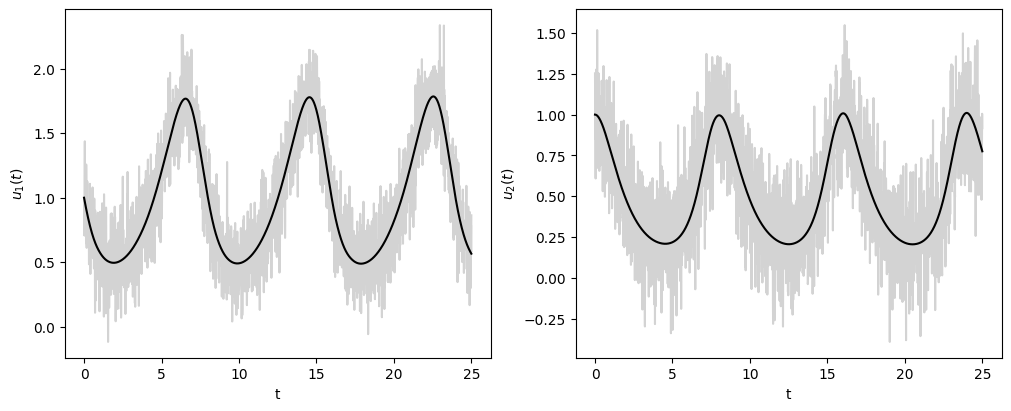

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for i in range(2):
    axs[i].plot(t, y[:, i], color='lightgray');
    axs[i].plot(t, u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

# Sample using a handwritten random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [10]:
def sample_chain(theta_sampler, theta_init, n_samples):
    """Sample a single chain of given length using the starting the values provided"""
    # set the starting values
    theta = np.array(theta_init, copy=True)

    # create an array for the trace
    trace = np.empty((n_samples + 1, d))

    # store the initial values
    trace[0, :] = theta

    # sample variables
    for i in range(n_samples):
        # sample new theta
        theta = theta_sampler(theta)

        # record the value in the trace
        trace[i + 1, :] = theta

    return trace

In [11]:
def to_arviz(chains, var_names):
    """Convert output to arviz format"""
    assert len(chains) > 0
    return az.from_dict({
        var_name: np.stack([chain[:, i] for chain in chains]) for i, var_name in enumerate(var_names)
    })

In [12]:
def metropolis_random_walk_step(log_target_density, proposal_sampler):
    """Perform a Metropolis-Hastings random walk step"""
    def sampler(theta):
        # propose a new value
        theta_proposed = proposal_sampler(theta)

        # decide whether to accept the new value
        log_acceptance_probability = np.minimum(
            0, 
            log_target_density(theta_proposed) - log_target_density(theta)
        )
        u = rng.random()
        if u == 0 or np.log(u) < log_acceptance_probability:
            return theta_proposed
        else:
            return theta

    return sampler

In [13]:
def log_target_density(theta):
    _, u = solve_lotka_volterra(np.exp(theta))
    log_likelihood = np.sum(stats.multivariate_normal.logpdf(y - u, mean=means, cov=C))
    log_prior = np.sum(stats.norm.logpdf(theta))
    return log_likelihood + log_prior

In [14]:
def rw_proposal_sampler(step_size):
    G = step_size * np.identity(d)
    def sampler(theta):
        xi = stats.norm.rvs(size=d, random_state=rng)
        return theta + G @ xi
    return sampler

In [15]:
n_samples = 50_000

In [16]:
# TODO consider selecting step size following Gelman, Roberts, Gilks (1996) Efficient Metropolis Jumping Rules.
step_size = 0.01

In [17]:
theta_init = np.array([0.55, 1, 0.8, 0.8])

In [18]:
%%time
theta_sampler = metropolis_random_walk_step(log_target_density, rw_proposal_sampler(step_size))
rw_sample = sample_chain(theta_sampler, np.log(theta_init), n_samples)

CPU times: user 10min 47s, sys: 759 ms, total: 10min 48s
Wall time: 10min 54s


Reproduce the first column in Figure S17 from the Supplementary Material:

In [19]:
def plot_trace(samples):
    fig, axs = plt.subplots(1, samples.shape[1], figsize=(15, 3), constrained_layout=True)
    for i in range(d):
        axs[i].plot(samples[:, i]);
        axs[i].set_xscale('log');
        axs[i].set_xlabel('n');
        axs[i].set_ylabel(f'Parameter {i + 1}');

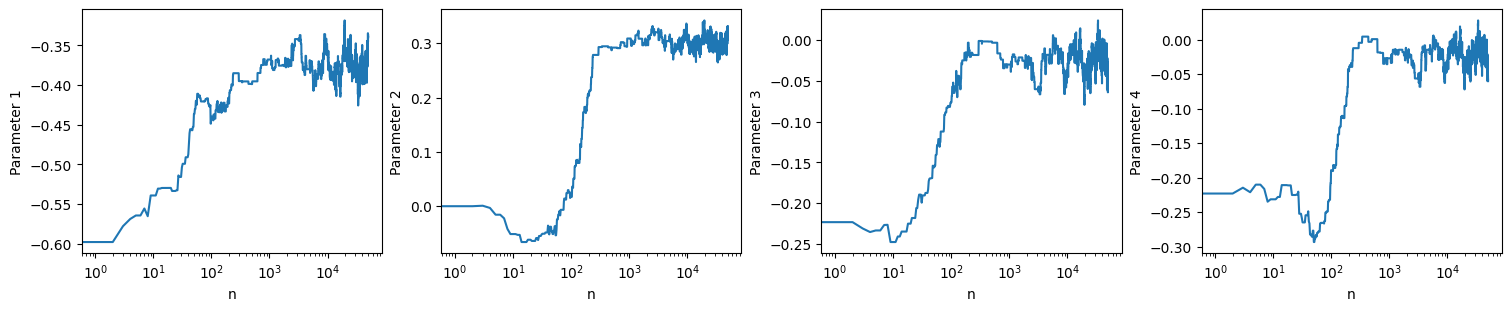

In [20]:
plot_trace(rw_sample)

# Sample using Stan

The implementation follows https://mc-stan.org/docs/stan-users-guide/odes.html#estimating-system-parameters-and-initial-state.

In [21]:
import nest_asyncio
nest_asyncio.apply()

In [22]:
stan_model_spec = """
functions {
  vector lotka_volterra(real t, vector u, vector theta) {
    vector[2] dudt;
    dudt[1] = exp(theta[1]) * u[1] - exp(theta[2]) * u[1] * u[2];
    dudt[2] = exp(theta[4]) * u[1] * u[2] - exp(theta[3]) * u[2];
    return dudt;
  }
}
data {
  int<lower=1> T;
  array[T] vector[2] y;
  real t0;
  array[T] real ts;
  vector[2] u0;
  vector<lower=0>[2] sigma;
}
parameters {
  vector[4] theta;
}
model {
  array[T] vector[2] u = ode_rk45(lotka_volterra, u0, t0, ts, theta);
  theta ~ std_normal();
  for (t in 1:T) {
    y[t] ~ normal(u[t], sigma);
  }
}
"""

In [23]:
data = {
    'T': t_n - 1,  # the first time is 0, for which the initial values are fixed
    'y': y[1:, :],
    't0': t_span[0],
    'ts': t[1:],
    'u0': u_init,
    'sigma': np.diag(C),  # TODO pass a matrix and use a multivariate normal in the Stan model
}

In [24]:
%%time
inference_model = stan.build(stan_model_spec, data=data, random_seed=12345)
stan_sample = inference_model.sample(num_chains=1, num_samples=n_samples, init=[{'theta': np.log(theta_init)}])

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_c56rs2u_/model_rmdlkygl.stan', line 22, column 25: The
    variable lotka_volterra may not have been assigned a value before its
    use.
Sampling:   0%
Sampling:   0% (1/51000)
Sampling:   0% (100/51000)
Sampling:   0% (200/51000)
Sampling:   1% (300/51000)
Sampling:   1% (400/51000)
Sampling:   1% (500/51000)
Sampling:   1% (600/51000)
Sampling:   1% (700/51000)
Sampling:   2% (800/51000)
Sampling:   2% (900/51000)
Sampling:   2% (1000/51000)
Sampling:   2% (1001/51000)
Sampling:   2% (1100/51000)
Sampling:   2% (1200/51000)
Sampling:   3% (1300/51000)
Sampling:   3% (1400/51000)
Sampling:   3% (1500/51000)
Sampling:   3% (1600/51000)
Sampling:   3% (1700/51000)
Sampling:   4% (1800/51000)
Sampling:   4% (1900/51000)
Sampling:   4% (2000/51000)
Sampling:   4% (2100/51000)
Sampling:   4% (2200/51000)
Sampling:   5% (2300/51000)
Sampling:   5% (2400/51000)
Sampling:   5% (2500/51000)
Sampling:   5% (2600/510

CPU times: user 2min 2s, sys: 15.7 s, total: 2min 18s
Wall time: 4h 28min 59s


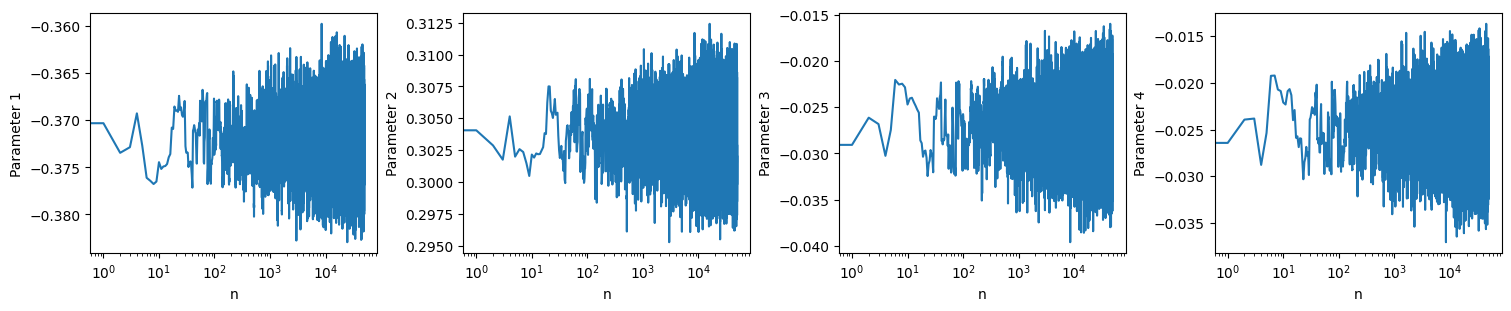

In [25]:
plot_trace(stan_sample['theta'].T)